# Microsoft Movie Studio Project

**Author**: Jonny Hofmeister

## Overview

This project explores movie data from IMDB and Box Office Mojo to generate business insights for a new movie studio.

## Business Problem

Microsoft has decided to enter the movie production industry and create a new movie studio, but they want some advice. This project asks and analyzes which types of films are doing best at the box office, and the results will inform decisions and actions Microsoft's studio and stakeholders can take to create successful production company and films.

<img src="./images/studio.jpeg" width="700"/>


## Questions this analysis aims to answer:

- Which genres in our data have the highest average domestic gross?

- Which genres have the highest average rating on IMDB

- How has the average gross of each genre changed over the recent years?

## Data Understanding

Box Office Mojo (BOM) is a webside run by IMDB that reports and organizes box office receipts from Movies. The essential data being pulled from this source is a Domestic and Foreign Gross for correspoding movies identified by a title. 

IMDB is a webside containing extensive details about individual movies. The datasets contain information like titles, year released, runtime, production, persons involed (actors, diretors, etc), and importantly, review data associated with each movie. 

We are given access to more sets of data, but for simplicity and consistency, this analysis will focus on a dataset created from the combination of these two sources.

### Import necessary packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns

from fuzzywuzzy import process, fuzz

In [2]:
# Filtering warnings to exclude unwanted output

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Data

In [3]:
# Load .CSV data using into DataFrames using Pandas

bom = pd.read_csv('data/bom.movie_gross.csv')
imdb_basics = pd.read_csv('data/imdb.title.basics.csv')
imdb_ratings = pd.read_csv('data/imdb.title.ratings.csv')

In [4]:
# First check out how the IMDB_basics data is organized

imdb_basics.head(2)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [5]:
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [6]:
# Now take a peek at the IMDB_ratings dataset

imdb_ratings.head(2)

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [7]:
imdb_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


### Data exploration

The IMDB Basics table includes essential information like movie titles and the genres they are associated with. The genres are stored in a single string, and each movie contains up to 3 associated genres. The data set contains 146,000 movies, quite a significant amount.

The IMDB Ratings table contains information on the movies average rating and the number of rating votes cast for that movie. The number of review movies is about 74000, about half that of the basics datatable, but still a very large amount, more than enough to work with. Movies that don't have ratings are also likely to be smaller, less-known or viewed and therefore less interesting to us from an analysis perspective as well.

We can see that both datasets include a column called 'tconst' which appears to be a unique identifier for each movie. This will work perfect to join both data tables. First lets check that 'tconst' is indeed unique and contains no duplicates.

In [8]:
imdb_basics.tconst.duplicated().value_counts()

False    146144
Name: tconst, dtype: int64

Perfect, 'tconst' is a unique identifier that contains no duplicates. This will work as the perfect index to join these two dataframes when the time comes.

Next let's get aquianted with the Box Office Mojo (BOM) data.

In [9]:
bom.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [10]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


BOM contains the very important gross information we are interested in for each movie title, as well as the year released, which will come in handy. The dataset is about 3300 movies, much smaller than the IMDB data. While we can't work with a gigantic set of movies anymore, a few thousand of the most important films still should be enough to glean some information on which movies have been most sucessful. I am going to explore success of movies though gross and also through rating, but when giving advice to Microsoft in building their studio, the more important information is the gross and how much money the movie made. 

## Data Preparation

We have a few items on the list to get the data ready to extract the information we want into figures. This includes cleaning the 'genres' column into something more useful than a string; merging the two IMDB dataframes on the 'tconst' index; and joining those to the BOM dataset by matching titles.

Matching titles could be done through cleaning methods like, making everything lowercase, removing punctuation, adding a year to the title, and then joining to hopefully get more correct matches. Instead of this, I have opted to utilize the FuzzyWuzzy package which applies the Levenshtein distance formula among other techniques to match string, returning the best match and a value rating how similar Fuzzy thinks the two strings are (value between 0 and 100). 

### Fuzzy matching

The script I have created to match BOM movie titles with IMDB movie titles is included in a separate .ipynb file for certain reasons. The main one being that the advanced searching algorithm took about an hour to run. For the sake of running this analysis notebook in its entirety, I have done this separately. 

Please refer to the bom_fuzzy.ipynb file for details on how this was done. At the end of the fuzzy script, I have saved the BOM dataframe, which includes matched titles, to a new .CSV file which I will import below and continue cleaning and merging. The file is called bom_fuzzy_matches.csv and is located in the data folder of the project repo.

In [11]:
# Let's take a peek at what these matches look like

bom_fuzzy_matches = pd.read_csv('data/bom_fuzzy_matches.csv')

In [12]:
bom_fuzzy_matches.head()

,title,studio,domestic_gross,foreign_gross,year,matched_title,similarity
0,Toy Story 3 2010,BV,415000000.0,652000000,2010,Toy Story 3 2010,100
1,Alice in Wonderland (2010) 2010,BV,334200000.0,691300000,2010,Alice in Wonderland 2010,87
2,Harry Potter and the Deathly Hallows Part 1 2010,WB,296000000.0,664300000,2010,Harry Potter and the Deathly Hallows: Part 1 2010,99
3,Inception 2010,WB,292600000.0,535700000,2010,Inception 2010,100
4,Shrek Forever After 2010,P/DW,238700000.0,513900000,2010,Shrek Forever After 2010,100


In [13]:
bom_fuzzy_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
 5   matched_title   3387 non-null   object 
 6   similarity      3387 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 185.4+ KB


Here in the matched dataframe, we still have the 'title' column which is the same as the titles in the original BOM data, the corresponding gross data and year. The two last columns are new. 'matched_title' is the title from the IMDB dataset that Fuzzy found to be most similar, as well as the similarity rating returned by the matching algorithm. We can filter the data by using this 'similarity' to include only matches we know Fuzzy is certain are the same. 

It is also important to note that the title and matched_title columns were updated before the matching process to include the year released after the title. This helped improve matching success. I would leave the years in there, as we wont be plotting by movie title, but in order to join this DataFrame with imdb_basics, I will have to remove the year in order to match the titles properly.

Another important note: As this was completely a few days ago, BOM and imdb_basics was fuzzy matched before I did any manipulation to the IMDB datasets. In the future I would do this in the opposite order. For example, first joining the imdb_basics and imdb_ratings would cut the size of our data in half, which in turn would reduce the Fuzzy matching runtime by about half. Given this still takes a while to re-run, and I have already saved the new .csv matching file, I will just continue to clean the data from here. We will end up with the same data in the end, but be aware this could have been done in a different order to improve efficiency. 

#### Before joining BOM and IMDB.....
I will join and clean the imdb_basics and imdb_ratings dataset, including cleaning the genres column to create a list of genres and a column for each with a True/False binary value to determine if the movie is in that genre. This will make selecting movies where a specific genre == True very simple.

I am also doing this before the BOM megre because that merge will decrease our dataset to only 3000 rows. I may also be interested in exploring the ratings of all IMDB moives without the BOM gross data. So first create a merged set of Basics and Ratings that inlcudes rating and genre information for 70k movies. Then this Dataframe is what I will join with the BOM fuzzy matches. This allows for slightly more flexibility in the size of the dataset while doing analysis and exploration. 

In [14]:
# First identify the index column for the merge, in this case it is the 'tconst' ID.

imdb_basics.set_index('tconst', inplace=True)
imdb_ratings.set_index('tconst', inplace=True)

In [15]:
# Now join. This is an inner join because we only want rows that have IDs in both dataframes in our new DF

basics_ratings = imdb_basics.join(imdb_ratings, how='inner')
basics_ratings.head()

,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
tconst,,,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [16]:
len(basics_ratings)

73856

We can see here this was a very sucessful join as the length of the result is the same as the length of the imdb_ratings dataframe. This means that each 'tconst' was indeed unique and every single movie in the ratings DF was found in the Basics DF.

In [17]:
# To eliminate confusion, I am going to drop the 'original_title' column from this DF. Primary_title was
# the one used in the fuzzy matching. So to not get mixed up, lets just delete the other title column.

# Note: original_title is generally the same as primary, but in some cases is a title in a different language,
# and primary title matched better witht the title in the BOM data

basics_ratings.drop(columns = 'original_title', inplace=True)

# Check it worked
basics_ratings.head(2)

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
tconst,,,,,,
tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43


The next step is to manipulate the genres column into something useful.
The steps I will go through to do this are first clean the genres string and split it by the commas, appending the individual genres into a list object containing anywhere from 0 to 3 genres. Then I will search through all genres to create a list of all genre types, then use this list to create a new column for each genre and ask each row if that genre is in the genres_list or not, and create a boolean value in that genre column if it is or isn't true.

In [18]:
# Here we split the genres column by the ',' delimiter and append to a new column containing individual
# genres in list format.

basics_ratings['list_genres'] = basics_ratings['genres'].map(lambda x: str(x).split(','))

basics_ratings.head(2)

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,list_genres
tconst,,,,,,,
tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,"[Action, Crime, Drama]"
tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43,"[Biography, Drama]"


Now let's make a list of all the genre types:

In [19]:
# Loop through each row in the data, then loop through the genres list in that row, 
# if we haven't come across that genre yet, append it to the list; if we have, skip it.

list_of_genre_types = []
for i in range(len(basics_ratings)):
    for x in basics_ratings['list_genres'][i]:
        if x in list_of_genre_types:
            continue
        elif x not in list_of_genre_types:
            list_of_genre_types.append(x)

A bit of genre cleaning: sorting genres alphabetically will be useful for bar plots.
Also, the 'Short' films genre only contains one entry, so it is basically useless.
The NaN genre is also not of any interest to us, so let's remove those genres right now too.

In [20]:
list_of_genre_types.sort()

list_of_genre_types.remove('Short')
list_of_genre_types.remove('nan')
list_of_genre_types

['Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

Sweet, we have all the genres organized in a useful list now. Next step is to iterate through this list, creating a new column in our dataframe for each genre that contains a True or False if that genre is contained in the movie's 'list_genres' list.

In [21]:
for genre in list_of_genre_types:
    basics_ratings[genre] = basics_ratings['list_genres'].map(lambda x: True if (genre in x) else False)

In [22]:
basics_ratings.head(3)

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,list_genres,Action,Adult,Adventure,...,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,"[Action, Crime, Drama]",True,False,False,...,False,False,False,False,False,False,False,False,False,False
tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43,"[Biography, Drama]",False,False,False,...,False,False,False,False,False,False,False,False,False,False
tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,[Drama],False,False,False,...,False,False,False,False,False,False,False,False,False,False


Perfect, now this dataframe and genres column can be selected to pull only movies that are in a certain genre.
This would look like "basics_ratings[basics_ratings['Action'] == True]' to choose only Action movies.

### Joining BOM data

Now that the IMDB data is prepped, we can continue to merge in the BOM gross data.

First, remove the year from the 'matched_title' in the bom_fuzzy_matches dataframe. Then merge that dataset with the imdb dataset on the title columns. 

In [23]:
# Can easily remove the year just by removing the last 5 characters from the title string.

bom_fuzzy_matches['matched_title'] = bom_fuzzy_matches['matched_title'].map(lambda x: str(x)[:-5])

In [24]:
# Check it worked

bom_fuzzy_matches['matched_title'].head(2)

0            Toy Story 3
1    Alice in Wonderland
Name: matched_title, dtype: object

One more thing before merging: lets only select the movies in the bom_fuzzy_matches dataframe where the FuzzyWuzzy was very sure the titles matched. I decided on the similarity cutoff value by scrolling through the dataframe with similarity < 100 and examining which ones were correct or not.

While similarties in the 80s were occasionally wrong, anything I found above 90 during my brief scroll had been matched correctly. We could lower this value a bit further, but the number of rows above 90 is 2789 out of the initial 3387. I am happy continuing with 82% of our data, this is a significant enough fraction. It is a benefit to know we are continuing with only matched data we are certain about than include mis-matches.

In [25]:
bom_matches = bom_fuzzy_matches[bom_fuzzy_matches['similarity'] > 90]

In [26]:
bom_matches.head()

,title,studio,domestic_gross,foreign_gross,year,matched_title,similarity
0,Toy Story 3 2010,BV,415000000.0,652000000,2010,Toy Story 3,100
2,Harry Potter and the Deathly Hallows Part 1 2010,WB,296000000.0,664300000,2010,Harry Potter and the Deathly Hallows: Part 1,99
3,Inception 2010,WB,292600000.0,535700000,2010,Inception,100
4,Shrek Forever After 2010,P/DW,238700000.0,513900000,2010,Shrek Forever After,100
5,The Twilight Saga: Eclipse 2010,Sum.,300500000.0,398000000,2010,The Twilight Saga: Eclipse,100


Also before we do the final merge, lets check for movie duplicates and remove them from each dataframe.

In [27]:
bom_matches.duplicated(subset='matched_title').value_counts()

False    2780
True        9
dtype: int64

In [28]:
basics_ratings.duplicated(subset='primary_title').value_counts()

False    69993
True      3863
dtype: int64

In [29]:
bom_matches = bom_matches.drop_duplicates(subset='matched_title')
basics_ratings = basics_ratings.drop_duplicates(subset='primary_title')

In [30]:
basics_ratings.duplicated(subset='primary_title').value_counts()

False    69993
dtype: int64

Now we have removed all the duplicate titles. This will ensure that we dont create extra duplicate rows while we do the final join. 

Some of these duplicate titles are becuase a movie was re-made or re-released in a different year. Unfortinately, our initial data in either dataframe is not specific enough to tell which may be which, and does often contain the same release year. To make it easy and quick, I have decided to get rid of all duplicates and keep the first. Most of these are real duplicates but most likely we are also losing a few movies that were released multiple times and have different gross and rating data for each. If the initial data was more clear it might be easy to create separate titles or IDs for these, but given my time constraint, I have elected to drop them rather than accidentally include duplicates.

Now we merge bom_matches with basics_ratings using an inner merge to select where matched_title and primary_title are the same.

In [31]:
df = bom_matches.merge(basics_ratings, left_on='matched_title', right_on='primary_title', how='inner')
df['domestic_gross']

0       415000000.0
1       296000000.0
2       292600000.0
3       238700000.0
4       300500000.0
           ...     
2762        12200.0
2763        11400.0
2764         8900.0
2765         6200.0
2766         1700.0
Name: domestic_gross, Length: 2767, dtype: float64

In [32]:
df['domestic_gross'] = df.dropna(subset=['domestic_gross'])['domestic_gross'].astype(int)/1000000

In [33]:
df['domestic_gross']

0       415.0000
1       296.0000
2       292.6000
3       238.7000
4       300.5000
          ...   
2762      0.0122
2763      0.0114
2764      0.0089
2765      0.0062
2766      0.0017
Name: domestic_gross, Length: 2767, dtype: float64

Great! This new dataframe now includes the movies the are included in both the BOM and IMDB dataset, so we can examine both gross and ratings and genre information for all of them. 

Examing the length of the result to the original, we only lost 13 rows from bom_matches. 2767 is the final length of our movie dataframe. Not terrible considering the smallest dataset we started with was 3387 movies.

## Plotting

### Rating
I will start with creating a bar chart of average movie rating for each genre

In [34]:
# First build a dictionary to store the genre and ratings in key value pairs
# for usefulness will also include the number of movies in each genre, so we can also see how many
# movies the rating is based off of. A genre with many movies is better data than a 
# genre with only one movie rating

ratings_dict = {}

for genre in list_of_genre_types:
    ratings_dict[genre] = {'average_rating': df[df[genre] == True]['averagerating'].mean(),
                           'number_movies': len(df[df[genre] == True])}

In [35]:
ratings_dict

{'Action': {'average_rating': 6.340094339622642, 'number_movies': 636},
 'Adult': {'average_rating': nan, 'number_movies': 0},
 'Adventure': {'average_rating': 6.4905405405405405, 'number_movies': 444},
 'Animation': {'average_rating': 6.664285714285714, 'number_movies': 168},
 'Biography': {'average_rating': 6.9813620071684594, 'number_movies': 279},
 'Comedy': {'average_rating': 6.247045951859956, 'number_movies': 914},
 'Crime': {'average_rating': 6.46994382022472, 'number_movies': 356},
 'Documentary': {'average_rating': 7.250243902439025, 'number_movies': 205},
 'Drama': {'average_rating': 6.602613129381772, 'number_movies': 1569},
 'Family': {'average_rating': 6.173684210526316, 'number_movies': 114},
 'Fantasy': {'average_rating': 6.2823529411764705, 'number_movies': 170},
 'Game-Show': {'average_rating': nan, 'number_movies': 0},
 'History': {'average_rating': 6.906201550387598, 'number_movies': 129},
 'Horror': {'average_rating': 5.7613861386138625, 'number_movies': 202},
 'Mu

Adult, game-show, and reality-tv genres all contain zero movies after we merged with BOM.
Let's delete those genres from the dictionary.

In [36]:
del ratings_dict['Adult']
del ratings_dict['Game-Show']
del ratings_dict['Reality-TV']

After more examination I think I would be good to trim the genres even more. News, Musical, and Western all contain very few movies. Lets remove them to make a more concise bar chart.

In [37]:
del ratings_dict['Musical']
del ratings_dict['News']
del ratings_dict['Western']

Now plot the rest of the genres ratings in a bar chart, in descending order with each colored by value to make it easy to read

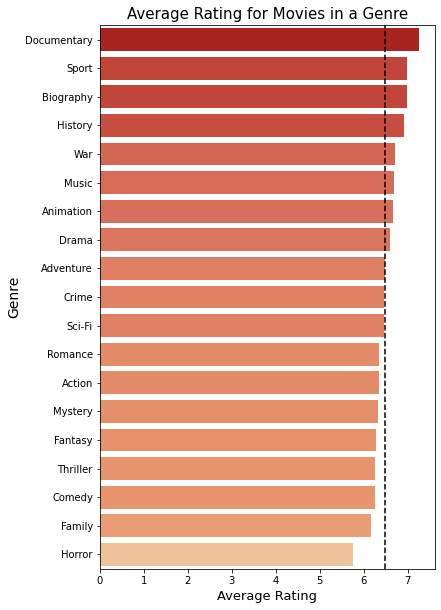

In [38]:
# First sort the ratings dictionary
ratings_dict_sorted = dict(sorted(ratings_dict.items(), key=lambda item: item[1]['average_rating']))


# From new sorted dictionary, make sorted lists for plotting
ratings_sorted = [value['average_rating'] for key, value in ratings_dict_sorted.items()][::-1]
genres_sorted = [key for key, value in ratings_dict_sorted.items()][::-1]

# Normalize colormap for data range
# Matplotlib normalize and ColorMap made this a very easy two liner
norm = plt.Normalize(min(ratings_sorted)-1, max(ratings_sorted)+.5)
colors = plt.cm.OrRd(norm(ratings_sorted))

# Define plot
fig, ax = plt.subplots(figsize=(6,10))


# Draw plot
sns.barplot(ratings_sorted, genres_sorted, palette = colors, orient='horizonatal')

# Add a line to show the average rating for all movies.
avg_rating = np.mean(df['averagerating'])
plt.axvline(x=avg_rating, ymin=0, ymax=1, color='k', linestyle='--')

# Set labels
ax.tick_params(axis='x', labelrotation = 0)
ax.set_xlabel('Average Rating', fontsize=13)
ax.set_ylabel('Genre', fontsize=14)
ax.set_title('Average Rating for Movies in a Genre', fontsize=15);

# the line below saves the figure to a .jpg in the images folder, uncomment to re-save
# fig.savefig('images/average_rating_genres.jpg', bbox_inches = "tight")

### Gross
Now build the same style plot but for the average gross for each genre.

In [39]:
gross_dict = {}

for genre in list_of_genre_types:
    gross_dict[genre] = {'average_gross': df[df[genre] == True]['domestic_gross'].mean(),
                           'number_movies': len(df[df[genre] == True])}

In [40]:
# To make it consistent with above plots, remove the same genres that do not contain enough movies
# or are not of enough interest

del gross_dict['Adult']
del gross_dict['Game-Show']
del gross_dict['Reality-TV']
del gross_dict['Musical']
del gross_dict['News']
del gross_dict['Western']

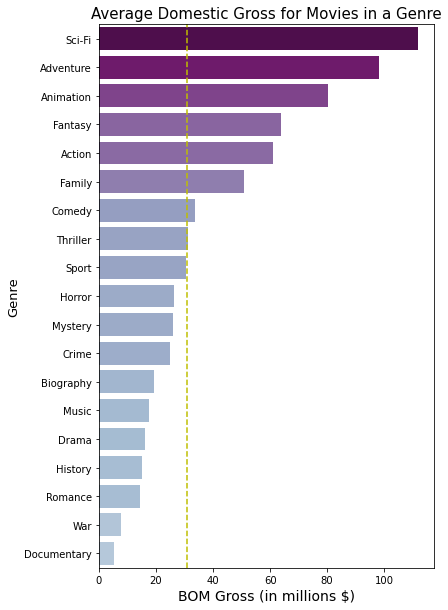

In [41]:
# First sort the ratings dictionary
gross_dict_sorted = dict(sorted(gross_dict.items(), key=lambda item: item[1]['average_gross']))


# From new sorted dictionary, make sorted lists for plotting
gross_sorted = [value['average_gross'] for key, value in gross_dict_sorted.items()][::-1]
genres_sorted = [key for key, value in gross_dict_sorted.items()][::-1]

# Normalize colormap for data range
# Matplotlib normalize and ColorMap made this a very easy two liner
norm = plt.Normalize(min(gross_sorted)-50, max(gross_sorted)+5)
# The numbers added to the min and max here are to use the central values of the colormap scale.
# When not trimmed, the low values are too light to be visible on the chart, so scale until it looks good.
colors = plt.cm.BuPu(norm(gross_sorted))

# Define plot
fig, ax = plt.subplots(figsize=(6,10))


# Draw plot
sns.barplot(gross_sorted, genres_sorted, palette = colors, orient='horizonatal')

# Add a line to show the average rating for all movies.
avg_gross = np.mean(df['domestic_gross'])
plt.axvline(x=avg_gross, ymin=0, ymax=1, color='y', linestyle='--')

# Set labels
ax.tick_params(axis='x', labelrotation = 0)
ax.set_ylabel('Genre', fontsize=13)
ax.set_xlabel('BOM Gross (in millions $)', fontsize=14)
ax.set_title('Average Domestic Gross for Movies in a Genre', fontsize=15);

# the line below saves the figure to a .jpg in the images folder, uncomment to re-save
fig.savefig('images/average_gross_genres.jpg', bbox_inches = "tight")

To look a little further at the top grossing genres, I am going to plot the distribution of Grosses for the top 5 genres. This is to check for outliers, and see if one genre has more extremely high grossers than the others.

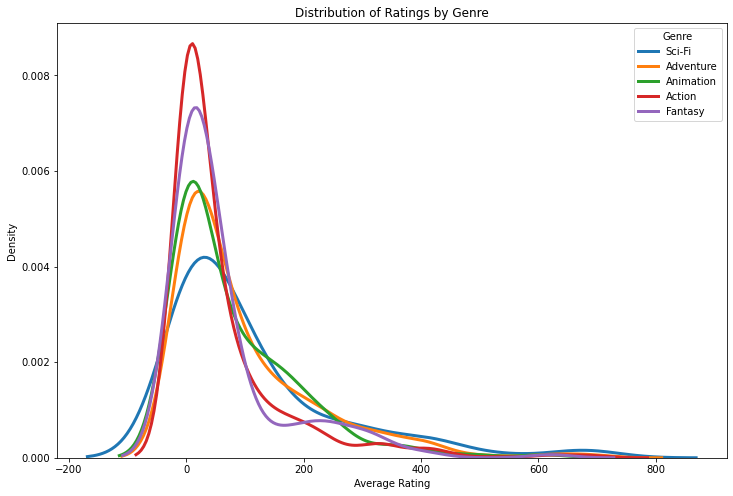

In [42]:
plot_genres = ['Sci-Fi', 'Adventure', 'Animation', 'Action', 'Fantasy']

fig, ax = plt.subplots(figsize=(12,8))

for genre in plot_genres:
    # Subset to the genre
    subset = df[df[genre] == True]
    
    # Draw the density plot
    sns.distplot(subset['domestic_gross'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = genre)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Genre', ncol=1)
plt.title('Distribution of Ratings by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Density');

It appears that Action and Fantasy may have slightly less films in the 200 Million range, but they still contain about the same maximum gross value as the others. We can also tell from the dataframe printed below that some of those very top grossers are included in multiple of the genre columns. For example, Black Panther is the highest domestic gross in the entire dataframe, and it belongs to the Sci-Fi, Action, and Adventure genres. 

It may be a factor that transcending multiple popular genres is part of the formula to making a top-grossing film.

In [43]:
df[df['domestic_gross']>500]

,title,studio,domestic_gross,foreign_gross,year,matched_title,similarity,primary_title,start_year,runtime_minutes,...,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
1500,Jurassic World 2015,Uni.,652.3,"1,019.4",2015,Jurassic World,100,Jurassic World,2015,124.0,...,False,False,False,False,False,True,False,False,False,False
1871,Rogue One: A Star Wars Story 2016,BV,532.2,523900000,2016,Rogue One: A Star Wars Story,100,Rogue One: A Star Wars Story,2016,133.0,...,False,False,False,False,False,True,False,False,False,False
2238,Star Wars: The Last Jedi 2017,BV,620.2,712400000,2017,Star Wars: The Last Jedi,100,Star Wars: The Last Jedi,2017,152.0,...,False,False,False,False,False,False,False,False,False,False
2514,Avengers: Infinity War 2018,BV,678.8,"1,369.5",2018,Avengers: Infinity War,100,Avengers: Infinity War,2018,149.0,...,False,False,False,False,False,True,False,False,False,False
2515,Black Panther 2018,BV,700.1,646900000,2018,Black Panther,100,Black Panther,2018,134.0,...,False,False,False,False,False,True,False,False,False,False
2517,Incredibles 2 2018,BV,608.6,634200000,2018,Incredibles 2,100,Incredibles 2,2018,118.0,...,False,False,False,False,False,False,False,False,False,False


Thinking about the forign gross column, it might be nice to combine those with domestic into a new total gross column.

In [44]:
df['foreign_gross'].isna().value_counts()

False    1654
True     1113
Name: foreign_gross, dtype: int64

Unfortunately, almost half of the rows are missing data for foreign gross. Maybe these movies were not released outside the US, or maybe their information is missing. We can also see above in the top grossing movies, foreign gross might not be reported consisently through the column. Most movies are written in long numbers on the order of hundreds of millions, but Avengers Infinity Wars and Jurassic World show values of 1,019.4 and 1,369.5. I am assuming this is in greater units than single dollars, perhaps millions or thousands of dollars. Since I do not know for sure, I am going to ignore the foreign gross column and not add it to the domestic grosses.

## Sort by Year

Next to visualize how trends in popular movies have changed in the past few decades, I will split the data into three time frames and find the Gross for each genre within those years. Note that the BOM data limits us as the movies in the set only range from 2010 to 2018.

The intervals I will use start at 2010 and are 3 years in length; 2010-2012, 2013-2015, 2016-2018. The X-axis on this plot will be genre, with 3 bars above each x-tick to show each year interval. Each interval will have a different colormap.

I think that rather than sorting the barchart by ascending Gross value, I will do it by genre alphabetically. Since 3 intervals are being plotted, sorting by one of those doesn't really help the visualizion. It would be more useful to alphabetically find the genre you are interested in and then look at its 3 intervals.

In [45]:
# first select data from the intervals we want

first_interval = df[(df['year'] <= 2012) & (df['year'] >= 2010)]
second_interval = df[(df['year'] <= 2015) & (df['year'] >= 2012)]
third_interval = df[(df['year'] <= 2018) & (df['year'] >= 2016)]

In [46]:
# Update the genres list so that I dont have to remove the columns after the fact.
to_remove = ['Adult', 'Game-Show', 'Reality-TV', 'Musical', 'News', 'Western']

trimmed_genres = [x for x in list_of_genre_types if x not in to_remove]

In [47]:
# Now loop through each interval dataframe on genre to pull average gross for each into a list

first_gross = [first_interval[first_interval[genre] == True]['domestic_gross'].mean() for genre in trimmed_genres]
second_gross = [second_interval[second_interval[genre] == True]['domestic_gross'].mean() for genre in trimmed_genres]
third_gross = [third_interval[third_interval[genre] == True]['domestic_gross'].mean() for genre in trimmed_genres]

In [48]:
# Next make a few dictionaries for the intervals and gross, this makes adding column titles to our
# data lists very easy and pandas reads them back into DFs without any issues

first_df = {'Genre': trimmed_genres, 'Average Gross': first_gross, 'Year Interval': '2010-2012'}
first_df = pd.DataFrame(first_df)
second_df = {'Genre': trimmed_genres, 'Average Gross': second_gross, 'Year Interval': '2013-2015'}
second_df = pd.DataFrame(second_df)
third_df = {'Genre': trimmed_genres, 'Average Gross': third_gross, 'Year Interval': '2016-2018'}
third_df = pd.DataFrame(third_df)

# Then concat them into the same DF again.
# Note the interval column that has been added, this allows us to use the 'hue' feature of 
# sns.barplot to easily group bars by the intervals identified in this column.
d = pd.concat([first_df, second_df, third_df])

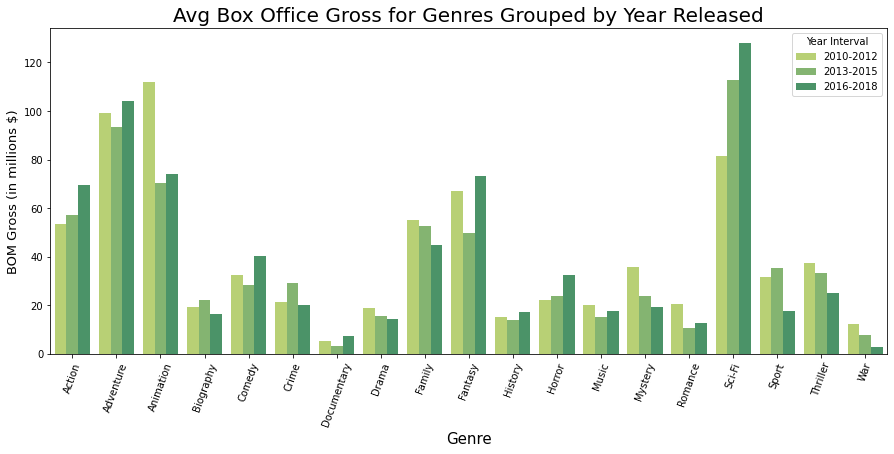

In [49]:
# Now plot, make it nice and long so its easily read
fig, ax = plt.subplots(figsize=(15,6))

# use seaborns 'hue' option to group data by the Year interval identifier created above
sns.barplot(x='Genre', y='Average Gross', hue='Year Interval', data=d, palette='summer_r')


# Set plot details
ax.tick_params(axis='x', labelrotation = 70)
ax.set_xlabel('Genre', fontsize=15)
ax.set_ylabel('BOM Gross (in millions $)', fontsize=13)
ax.set_title('Avg Box Office Gross for Genres Grouped by Year Released', fontsize=20);

# the line below saves the figure to a .jpg in the images folder, uncomment to re-save
# fig.savefig('images/interval_grosses.jpg', bbox_inches = "tight")

Great! Now we can see how the average gross of each genre has changed during the three, three year intervals we have BOM movie data for. Most sta generally consistent or move up and down. Sci-Fi has increased the most across the intervals. Animation has decreased the most, but in the later two intervals has had consistent grossing, and still remains with a higher domestic gross average than most other genres.

## Results

In response to the three questions listed at the beginning of the analysis.

- The top 5 grossing genres in descending order are Sci-Fi, Adventure, Animation, Fantasy, Action.

- The top rated genres on IMDB (for movies that are also contained in the BOM dataset) are Documentary, Sport, Biography, and History.

- Sci-Fi's average gross has increased significantly since 2010. Animation has decreased in gross the most since 2010.

## Conclusions

From these results we can make conclusions and reccommendations to the stakeholders and people involved in creating Microsoft's new movie studio. 

1. To generate the most return in the box office from movie production investment, I reccommend Microsoft's new studio focus on creating movies in the top grossing genres, or at least ones above the box office gross average across all movies.

    - The top 5 genres are Sci-Fi, Adventure, Animation, Fantasy, and Action. Starting with movies in these genres will help to get to studio immediately turning profit and to help the studio achieve their first 'blockbuster', which will generate as much recognition for the studio as it will profit.
    
    - Family, Comedy, Thriller, and Sport movies are also more often than not above the average domestic gross for all movies and would be good choices for Microsoft studio productions.
    

2. Creating a well-recognized studio and turning profit does not just come from the box-office though. That is why I reccommend Microsoft's new studio focus some investment in creating movies/content that is rated highly by viewers. In our modern Netflix-era, production companies can generate revenue from films long after they air in theatre. The best ways they can do this are air them on TV or add them to streaming services. Ratings are a very important factor in determining if a user will select to watch that film, or if the film appears on the front page of the streaming service and is reccommended.

    - Documentary, Sportsd, Biography, and History are the highest rated genres on IMDB. Interestingly, these categories overlap often.
    
    - You may notice Doc and Bio are some of the lowest grossing genres in our data. This may not be a huge deal as nowdays, Documentaries are not often released in the theatre, but go straight to streaming services. In keeping up with popular trends in streaming, and in diversifying the new studios porfolio, I reccommend Mircosoft invest in creating content that will be have good ratings and be successful in the long run on modern-day viewing platforms. 
    
    
3. In examining how well each genre has done over recent years, it appears Sci-Fi has been growing in box office profit. I reccommend Mircosoft's studio follow these popular trends.

    - I reccommend Mircosoft go for a Sci-Fi movie as it is the highest grossing genre and has appears to also be the fastest growing. Superhero movies are a great example of modern popular Sci-Fi's and are among the top grossing films.
    
    - Black Panther is a superhero movie, and a Sci-Fi, and it the highest domestic gross in our data. It is also included in two of the other top grossing genres. I reccommend Mircosoft not just pick the top genre to create movies in, but to write movies that transcend the top few genres, appealing to more kinds of viewers and showing up in more categories on streaming services. 

### Next Steps

- Improve the size of our dataset by finding and including movies newer than 2018. 

- Looking at foreign gross profits compared to domestic, and make a reccommendation to the studio if they should release films and focus on markets internationally.

- Findng data from streaming serivces like Netflix, to find how a new production studio may best profit in a modern movie streaming market. Perhaps even by creating/buying Mircosofts own content streaming platform.